In [1]:
import numpy as np
import pandas as pd
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import adabound
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler

torch.cuda.is_available()

False

In [2]:
mydata = pd.read_csv('D:/Cho Lab Dropbox/연구과제별정리/02 목적과제_SPPEC_암종별(임상)_상희회준/위암/03 머신러닝_회준종혁다혜/01 Model/다혜/DL_data_2211.csv')

In [3]:
mydata = mydata[mydata['Age']>74]

In [4]:
event_data = mydata['Clavien_Dindo']
pd.crosstab(mydata['OP_year'], mydata['Clavien_Dindo'])

Clavien_Dindo,0,1,2
OP_year,,,
2014,62,7,5
2015,52,8,2
2016,53,7,5
2017,54,9,8
2018,40,8,8
2019,43,2,7
2020,53,18,8
2021,25,24,12


In [5]:
x_dat = mydata[[ 
        'Age',
        'Platelets',
        'Albumin',
        'Cell_Count',
        'WBC',
        'Hemoglobin',
        'Segmented_neutrophil',
        'ANC',
        'Lymphocytes',
        'NLR',
        'PNI',
        'SII',
        'OP_time',
        'EBL',
    
        'Hemoglobin_status',
        'Neutrophil_count_status',
        'Sex',
        'ASA_Score',
        'Smoking',
        'Drinking',
        'BMI',
        'Hypertension',
        'Diabetes',
        'Ass_condition_grp',
        'Ass_lesion',
        'Clinical_Stage',
        'Histology',
        'Lauren',
        'Reconstruction',
        'Combined_Resection',
        
                     'fStage',
                'Location',
                'LN_Dissection',
                'Operation',
                'Intraop_cc'
              
               ]]

In [6]:
nsubject = mydata.shape[0]

In [7]:
contvar = ['Age', "Platelets", "Albumin", "Cell_Count", 'WBC',
        'Hemoglobin',
        'Segmented_neutrophil',
        'ANC',
        'Lymphocytes',
        'NLR',
        'PNI',
        'SII',
          'OP_time', 
           'EBL']
catevar= x_dat.columns[[x not in contvar for x in x_dat.columns]]


In [8]:
x_dat2 = x_dat.copy()
x_dat2[catevar] = x_dat2[catevar].astype("category")

print(x_dat2.dtypes)

Age                           int64
Platelets                     int64
Albumin                     float64
Cell_Count                  float64
WBC                         float64
Hemoglobin                  float64
Segmented_neutrophil        float64
ANC                           int64
Lymphocytes                 float64
NLR                         float64
PNI                         float64
SII                           int64
OP_time                       int64
EBL                         float64
Hemoglobin_status          category
Neutrophil_count_status    category
Sex                        category
ASA_Score                  category
Smoking                    category
Drinking                   category
BMI                        category
Hypertension               category
Diabetes                   category
Ass_condition_grp          category
Ass_lesion                 category
Clinical_Stage             category
Histology                  category
Lauren                     c

In [9]:
x_dat3 = pd.get_dummies(x_dat2, columns=catevar)
X_dat = x_dat3.to_numpy()

In [10]:
X_dat.shape

(520, 73)

In [11]:
OP_year = mydata['OP_year']
#testindex = np.isin(OP_year, [2020, 2021])
testindex = np.isin(OP_year, [2015, 2017, 2019, 2021])

In [12]:
X_train = X_dat[np.invert(testindex)].copy()
event_train = event_data.values[np.invert(testindex)].copy()

X_test = X_dat[testindex].copy()
event_test = event_data.values[testindex].copy()

ntrain = X_train.shape[0]
nsubject, ntrain, nsubject-ntrain

(520, 274, 246)

In [13]:
continuous_train=X_train[:, 0:14]
continuous_test=X_test[:, 0:14]

In [14]:
cont_train_RobustScaler = RobustScaler().fit_transform(continuous_train)
stdX_train = X_train.copy()
stdX_train[:, 0:14]=cont_train_RobustScaler

In [15]:
cont_test_RobustScaler = RobustScaler().fit_transform(continuous_test)
stdX_test = X_test.copy()
stdX_test[:, 0:14]=cont_test_RobustScaler

In [16]:
num_event = 2
batch_size = 256
hidden_size = 256

train_data = []
for i in range(ntrain):
    train_data.append([stdX_train[i], event_train[i]])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
train_loader

In [17]:
cuda = torch.cuda.is_available() # False
if cuda:
    device = 'cuda:0'
else:
    device = 'cpu'

In [18]:
class MLP(nn.Module):
    
    def __init__(self, input_size, hidden_size=128, num_layer=1, num_event=2):
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.num_event = num_event
        
        self.hidden_in = nn.Linear(self.input_size, self.hidden_size)
        hiddens = [
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
        ]
        self.hiddens = nn.Sequential(*((num_layer-1)*hiddens))
        self.hidden_out = nn.Linear(self.hidden_size, self.num_event+1)
        self.activation = nn.LeakyReLU(inplace=True)
                
    def forward(self, x):
        ## x: (batch, input_size)

        batch_size = x.shape[0]
        x = self.hidden_in(x)
        x = self.hiddens(self.activation(x))
        x = self.hidden_out(x)
        
        return x

In [20]:
stdX_train.shape[-1]

73

In [21]:
model = MLP(input_size=73, hidden_size=32, num_layer=2, num_event=num_event).to(device)
model

MLP(
  (hidden_in): Linear(in_features=73, out_features=32, bias=True)
  (hiddens): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (hidden_out): Linear(in_features=32, out_features=3, bias=True)
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
)

Drive/01 Research work/gastric_comp/models/75+/MultiMLP_16hiddensize_1layers_1e-03
Epoch: 0, Loss: 1.1406e+00


C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\adabound\adabound.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1055.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch: 100, Loss: 6.6881e-01
Epoch: 200, Loss: 6.0776e-01
Epoch: 300, Loss: 6.2698e-01
Epoch: 400, Loss: 4.4985e-01
Epoch: 500, Loss: 4.7717e-01
Epoch: 600, Loss: 4.0025e-01
Epoch: 700, Loss: 3.0900e-01
Epoch: 800, Loss: 2.5924e-01
Epoch: 900, Loss: 3.6964e-01
Epoch: 1000, Loss: 2.4880e-01
Epoch: 1100, Loss: 3.4702e-01
Epoch: 1200, Loss: 2.0047e-01
Epoch: 1300, Loss: 1.8340e-01
Epoch: 1400, Loss: 1.8586e-01
Epoch: 1500, Loss: 1.4967e-01
Epoch: 1600, Loss: 1.1124e-01
Epoch: 1700, Loss: 9.2038e-02
Epoch: 1800, Loss: 1.1702e-01
Epoch: 1900, Loss: 8.7440e-02
Epoch: 2000, Loss: 1.0326e-01
Epoch: 2100, Loss: 7.1692e-02
Epoch: 2200, Loss: 6.6556e-02
Epoch: 2300, Loss: 5.6511e-02
Epoch: 2400, Loss: 6.2557e-02
Epoch: 2500, Loss: 8.1713e-02
Epoch: 2600, Loss: 7.3593e-02
Epoch: 2700, Loss: 5.0383e-02
Epoch: 2800, Loss: 4.8404e-02
Epoch: 2900, Loss: 5.5923e-02
Epoch: 3000, Loss: 5.1043e-02
Epoch: 3100, Loss: 4.7109e-02
Epoch: 3200, Loss: 3.9528e-02
Epoch: 3300, Loss: 4.2452e-02
Epoch: 3400, Loss: 

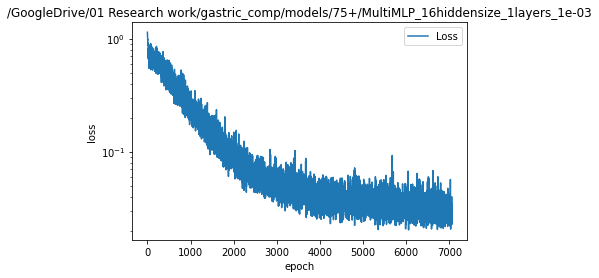

Drive/01 Research work/gastric_comp/models/75+/MultiMLP_16hiddensize_1layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.6016
Train precision = 1.0000, Test precision = 0.5867
Train recall = 1.0000, Test recall = 0.6016
Train F1 score = 1.0000, Test F1 score = 0.5924
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.5387
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.3799
Drive/01 Research work/gastric_comp/models/75+/MultiMLP_16hiddensize_2layers_1e-03
Epoch: 0, Loss: 1.0778e+00
Epoch: 100, Loss: 6.1419e-01
Epoch: 200, Loss: 6.5462e-01
Epoch: 300, Loss: 7.1209e-01
Epoch: 400, Loss: 4.0178e-01
Epoch: 500, Loss: 4.4861e-01
Epoch: 600, Loss: 3.0518e-01
Epoch: 700, Loss: 2.1795e-01
Epoch: 800, Loss: 1.7602e-01
Epoch: 900, Loss: 7.4478e-02
Epoch: 1000, Loss: 7.7309e-02
Epoch: 1100, Loss: 7.4093e-02
Epoch: 1200, Loss: 5.4022e-02
Epoch: 1300, Loss: 6.

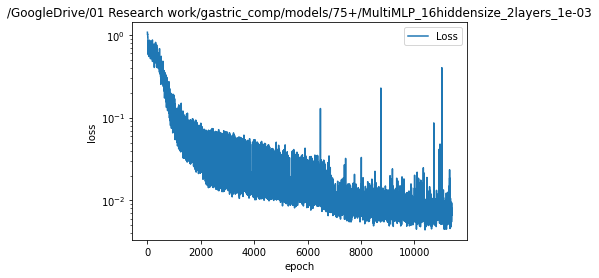

Drive/01 Research work/gastric_comp/models/75+/MultiMLP_16hiddensize_2layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.6098
Train precision = 1.0000, Test precision = 0.5635
Train recall = 1.0000, Test recall = 0.6098
Train F1 score = 1.0000, Test F1 score = 0.5832
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.4930
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.4427
Drive/01 Research work/gastric_comp/models/75+/MultiMLP_32hiddensize_1layers_1e-03
Epoch: 0, Loss: 1.1468e+00
Epoch: 100, Loss: 5.8367e-01
Epoch: 200, Loss: 6.7293e-01
Epoch: 300, Loss: 5.1246e-01
Epoch: 400, Loss: 4.1326e-01
Epoch: 500, Loss: 3.6539e-01
Epoch: 600, Loss: 2.9637e-01
Epoch: 700, Loss: 2.1979e-01
Epoch: 800, Loss: 2.1205e-01
Epoch: 900, Loss: 1.4889e-01
Epoch: 1000, Loss: 1.8331e-01
Epoch: 1100, Loss: 1.7360e-01
Epoch: 1200, Loss: 1.0572e-01
Epoch: 1300, Loss: 1.

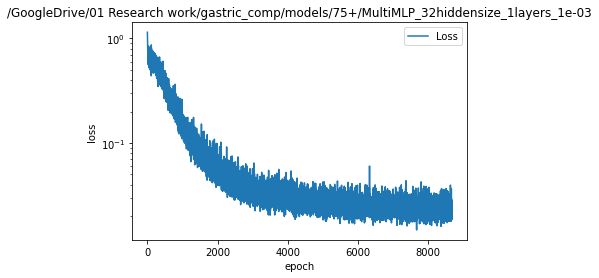

Drive/01 Research work/gastric_comp/models/75+/MultiMLP_32hiddensize_1layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.5569
Train precision = 1.0000, Test precision = 0.5459
Train recall = 1.0000, Test recall = 0.5569
Train F1 score = 1.0000, Test F1 score = 0.5506
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.4782
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.3876
Drive/01 Research work/gastric_comp/models/75+/MultiMLP_32hiddensize_2layers_1e-03
Epoch: 0, Loss: 1.1379e+00
Epoch: 100, Loss: 6.4379e-01
Epoch: 200, Loss: 7.5399e-01
Epoch: 300, Loss: 6.3044e-01
Epoch: 400, Loss: 4.8364e-01
Epoch: 500, Loss: 3.7513e-01
Epoch: 600, Loss: 1.9634e-01
Epoch: 700, Loss: 1.8921e-01
Epoch: 800, Loss: 1.9913e-01
Epoch: 900, Loss: 8.8652e-02
Epoch: 1000, Loss: 6.9011e-02
Epoch: 1100, Loss: 5.8560e-02
Epoch: 1200, Loss: 4.2658e-02
Epoch: 1300, Loss: 5.

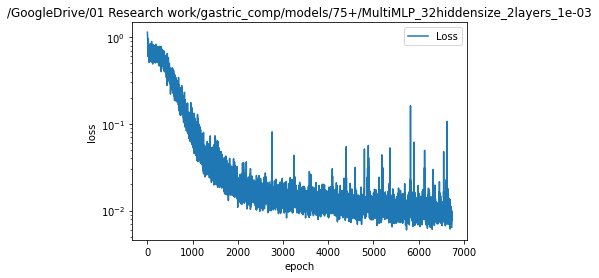

Drive/01 Research work/gastric_comp/models/75+/MultiMLP_32hiddensize_2layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.5447
Train precision = 1.0000, Test precision = 0.5414
Train recall = 1.0000, Test recall = 0.5447
Train F1 score = 1.0000, Test F1 score = 0.5429
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.4944
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.4426
Drive/01 Research work/gastric_comp/models/75+/MultiMLP_64hiddensize_1layers_1e-03
Epoch: 0, Loss: 1.0246e+00
Epoch: 100, Loss: 6.1839e-01
Epoch: 200, Loss: 7.0700e-01
Epoch: 300, Loss: 5.1895e-01
Epoch: 400, Loss: 4.3462e-01
Epoch: 500, Loss: 3.4334e-01
Epoch: 600, Loss: 1.9714e-01
Epoch: 700, Loss: 1.3706e-01
Epoch: 800, Loss: 1.2423e-01
Epoch: 900, Loss: 1.2775e-01
Epoch: 1000, Loss: 7.7230e-02
Epoch: 1100, Loss: 7.4692e-02
Epoch: 1200, Loss: 7.1226e-02
Epoch: 1300, Loss: 6.

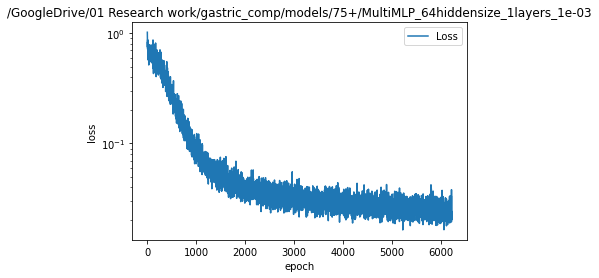

Drive/01 Research work/gastric_comp/models/75+/MultiMLP_64hiddensize_1layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.6016
Train precision = 1.0000, Test precision = 0.5529
Train recall = 1.0000, Test recall = 0.6016
Train F1 score = 1.0000, Test F1 score = 0.5748
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.4977
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.4124
Drive/01 Research work/gastric_comp/models/75+/MultiMLP_64hiddensize_2layers_1e-03
Epoch: 0, Loss: 1.0367e+00
Epoch: 100, Loss: 5.5939e-01
Epoch: 200, Loss: 6.5764e-01
Epoch: 300, Loss: 4.1570e-01
Epoch: 400, Loss: 3.1734e-01
Epoch: 500, Loss: 2.1468e-01
Epoch: 600, Loss: 1.7836e-01
Epoch: 700, Loss: 1.4760e-01
Epoch: 800, Loss: 7.8139e-02
Epoch: 900, Loss: 7.8721e-02
Epoch: 1000, Loss: 6.1877e-02
Epoch: 1100, Loss: 3.8839e-02
Epoch: 1200, Loss: 4.0022e-02
Epoch: 1300, Loss: 2.

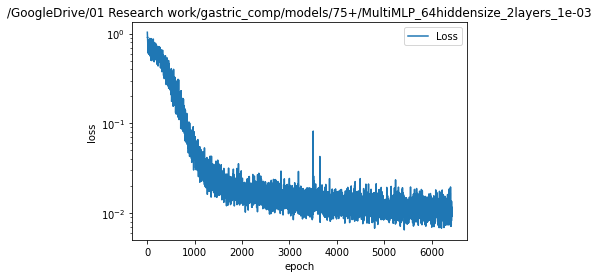

Drive/01 Research work/gastric_comp/models/75+/MultiMLP_64hiddensize_2layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.6057
Train precision = 1.0000, Test precision = 0.5611
Train recall = 1.0000, Test recall = 0.6057
Train F1 score = 1.0000, Test F1 score = 0.5807
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.5558
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.3747
Drive/01 Research work/gastric_comp/models/75+/MultiMLP_128hiddensize_1layers_1e-03
Epoch: 0, Loss: 1.1891e+00
Epoch: 100, Loss: 4.9393e-01
Epoch: 200, Loss: 5.9904e-01
Epoch: 300, Loss: 5.0781e-01
Epoch: 400, Loss: 4.5644e-01
Epoch: 500, Loss: 2.7693e-01
Epoch: 600, Loss: 2.2168e-01
Epoch: 700, Loss: 2.1344e-01
Epoch: 800, Loss: 1.1390e-01
Epoch: 900, Loss: 1.0757e-01
Epoch: 1000, Loss: 9.4772e-02
Epoch: 1100, Loss: 7.8354e-02
Epoch: 1200, Loss: 7.7228e-02
Epoch: 1300, Loss: 5

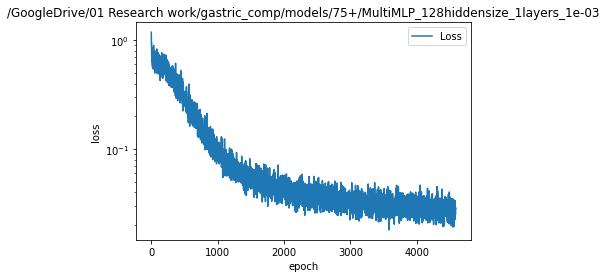

Drive/01 Research work/gastric_comp/models/75+/MultiMLP_128hiddensize_1layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.6423
Train precision = 1.0000, Test precision = 0.5897
Train recall = 1.0000, Test recall = 0.6423
Train F1 score = 1.0000, Test F1 score = 0.6110
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.5120
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.4522
Drive/01 Research work/gastric_comp/models/75+/MultiMLP_128hiddensize_2layers_1e-03
Epoch: 0, Loss: 1.0811e+00
Epoch: 100, Loss: 6.0588e-01
Epoch: 200, Loss: 6.5056e-01
Epoch: 300, Loss: 5.4924e-01
Epoch: 400, Loss: 4.2664e-01
Epoch: 500, Loss: 3.9042e-01
Epoch: 600, Loss: 2.4976e-01
Epoch: 700, Loss: 3.1429e-01
Epoch: 800, Loss: 1.5454e-01
Epoch: 900, Loss: 1.1558e-01
Epoch: 1000, Loss: 5.6809e-02
Epoch: 1100, Loss: 5.2305e-02
Epoch: 1200, Loss: 4.8762e-02
Epoch: 1300, Loss: 

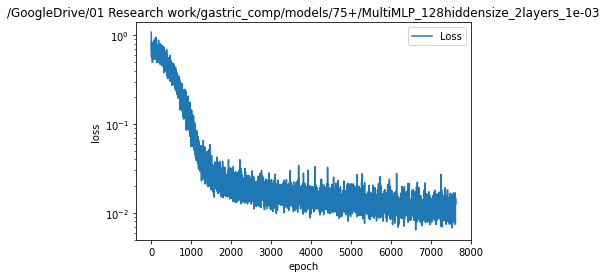

Drive/01 Research work/gastric_comp/models/75+/MultiMLP_128hiddensize_2layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.6382
Train precision = 1.0000, Test precision = 0.6064
Train recall = 1.0000, Test recall = 0.6382
Train F1 score = 1.0000, Test F1 score = 0.6196
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.6066
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.4402
Drive/01 Research work/gastric_comp/models/75+/MultiMLP_256hiddensize_1layers_1e-03
Epoch: 0, Loss: 1.1251e+00
Epoch: 100, Loss: 5.6665e-01
Epoch: 200, Loss: 4.9170e-01
Epoch: 300, Loss: 4.3856e-01
Epoch: 400, Loss: 2.6943e-01
Epoch: 500, Loss: 1.8508e-01
Epoch: 600, Loss: 1.5671e-01
Epoch: 700, Loss: 1.6474e-01
Epoch: 800, Loss: 1.1744e-01
Epoch: 900, Loss: 1.0315e-01
Epoch: 1000, Loss: 9.2014e-02
Epoch: 1100, Loss: 8.9282e-02
Epoch: 1200, Loss: 7.6791e-02
Epoch: 1300, Loss: 

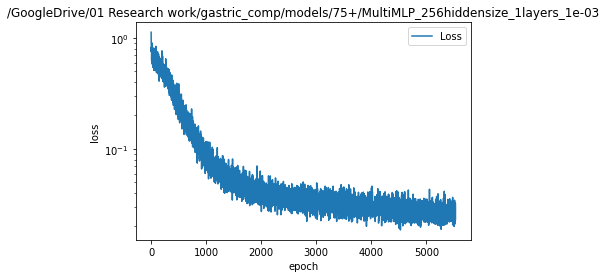

Drive/01 Research work/gastric_comp/models/75+/MultiMLP_256hiddensize_1layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.6220
Train precision = 1.0000, Test precision = 0.5667
Train recall = 1.0000, Test recall = 0.6220
Train F1 score = 1.0000, Test F1 score = 0.5904
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.5353
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.4608
Drive/01 Research work/gastric_comp/models/75+/MultiMLP_256hiddensize_2layers_1e-03
Epoch: 0, Loss: 9.6574e-01
Epoch: 100, Loss: 7.4848e-01
Epoch: 200, Loss: 6.4461e-01
Epoch: 300, Loss: 6.0240e-01
Epoch: 400, Loss: 4.2091e-01
Epoch: 500, Loss: 5.7789e-01
Epoch: 600, Loss: 3.6518e-01
Epoch: 700, Loss: 2.9360e-01
Epoch: 800, Loss: 2.5495e-01
Epoch: 900, Loss: 3.0915e-01
Epoch: 1000, Loss: 1.7831e-01
Epoch: 1100, Loss: 2.2184e-01
Epoch: 1200, Loss: 1.7618e-01
Epoch: 1300, Loss: 

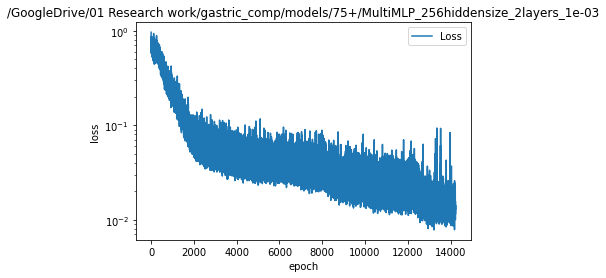

Drive/01 Research work/gastric_comp/models/75+/MultiMLP_256hiddensize_2layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.6220
Train precision = 1.0000, Test precision = 0.5732
Train recall = 1.0000, Test recall = 0.6220
Train F1 score = 1.0000, Test F1 score = 0.5946
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.5636
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.4510


In [22]:
criterion = nn.CrossEntropyLoss()

for weight_decay in [1e-3]:
    for hidden_size in [16, 32, 64, 128, 256]:
        for num_layer in [1, 2]:
            
            path = 'D:/GoogleDrive/01 Research work/gastric_comp/models/75+/MultiMLP_{}hiddensize_{}layers_{:.0e}'.format(hidden_size, num_layer, weight_decay)
            #if os.path.isfile(path):
            #    continue
            print(path[9:])

            model = MLP(input_size=stdX_train.shape[-1], hidden_size=hidden_size, num_layer=num_layer, num_event=num_event).to(device)
            if os.path.isfile(path):
                model.load_state_dict(torch.load(path, map_location = device))

            lr = 1e-3
            optimizer = adabound.AdaBound(model.parameters(), lr=lr, weight_decay=0)

            loss_array = []
            patience = 0
            min_loss = np.inf
            for e in range(int(1e6)):

                loss_array_tmp = []

                for stdX_train_batch, event_batch in train_loader:

                    total_batch = stdX_train_batch.float()
                    event_batch = event_batch.long()

                    y_pred = model(total_batch.to(device))

                    norm = 0.
                    for parameter in model.parameters():
                        norm += torch.norm(parameter, p=1)

                    loss1 = criterion(y_pred, event_batch.to(device))

                    loss = loss1 + weight_decay*norm
                    loss_array_tmp.append(loss1.item())

                    model.zero_grad()

                    loss.backward()

                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                loss_array.append(np.mean(loss_array_tmp))
                if e % 100 == 0:
                    print('Epoch: ' + str(e) + 
                          ', Loss: '+ f'{loss_array[-1]:.4e}')
                if min_loss > loss_array[-1]:
                    patience = 0
                    min_loss = loss_array[-1]
                    torch.save(model.state_dict(), path)
                else:
                    patience += 1

                torch.cuda.empty_cache()

                if patience > 1000:
                    break

            plt.plot(loss_array, label='Loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.yscale('log')
            plt.title(path[2:])
            plt.legend()
            plt.show()

            total_train_sort = torch.FloatTensor(stdX_train)
            total_test_sort = torch.FloatTensor(stdX_test)

            model.load_state_dict(torch.load(path, map_location = device))

            y_train = torch.softmax(model(total_train_sort.to(device)), 1).detach().cpu().numpy()
            y_test = torch.softmax(model(total_test_sort.to(device)), 1).detach().cpu().numpy()

            out_pred = np.where(y_train >= 0.5, 1, 0)
            acc_train = accuracy_score(event_train, out_pred.argmax(1))
            auc_train_mild = roc_auc_score(event_train == 1, y_train[:,1])
            auc_train_severedeath = roc_auc_score(event_train == 2, y_train[:,2])
            precision_train = precision_score(event_train, out_pred.argmax(1), average='weighted')
            recall_train = recall_score(event_train, out_pred.argmax(1), average='weighted')
            F1_train = f1_score(event_train, out_pred.argmax(1), average='weighted')
            
            out_pred = np.where(y_test >= 0.5, 1, 0)
            acc_test = accuracy_score(event_test, out_pred.argmax(1))
            auc_test_mild = roc_auc_score(event_test == 1, y_test[:,1])
            auc_test_severedeath = roc_auc_score(event_test == 2, y_test[:,2])
            precision_test = precision_score(event_test, out_pred.argmax(1), average='weighted')
            recall_test = recall_score(event_test, out_pred.argmax(1), average='weighted')
            F1_test = f1_score(event_test, out_pred.argmax(1), average='weighted')
            
            print('=====================================================================================')
            print(path[9:])
            print('-----------------------------------------------------------------------------')

            print('Train accuracy = {:.4f}, Test accuracy = {:.4f}'.format(acc_train, acc_test))
            print('Train precision = {:.4f}, Test precision = {:.4f}'.format(precision_train, precision_test))
            print('Train recall = {:.4f}, Test recall = {:.4f}'.format(recall_train, recall_test))
            print('Train F1 score = {:.4f}, Test F1 score = {:.4f}'.format(F1_train, F1_test))
            print('-------------------------------------------------------')

            print('Event: Mild; Train AUC = {:.4f}, Test AUC = {:.4f}'.format(auc_train_mild, auc_test_mild))
            print('Event: Severe, death; Train AUC = {:.4f}, Test AUC = {:.4f}'.format(auc_train_severedeath, auc_test_severedeath))
            print('=======================================================')